In [1]:
# Loading libraries required and reading dataset into python
import pandas as pd
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
# Modeling
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_squared_error as mae,r2_score
from sklearn import linear_model
import sklearn.model_selection as ms
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
df_final = pd.read_csv('cleaned_cars.csv')
df_final = df_final.drop(columns = ['Unnamed: 0'],axis = 1)

In [3]:
df_final.shape

(19279, 15)

In [4]:
data = df_final.sample(frac = 0.15)
data.shape

(2892, 15)

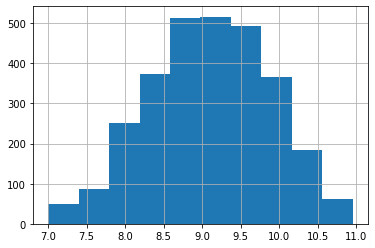

In [5]:
data.price_log.hist()

In [6]:
data.describe()

,year,price_log,odometer_log
count,2892.000000,2892.000000,2892.000000
mean,2008.928423,9.088228,11.510168
std,6.585735,0.773047,0.690731
min,1965.000000,7.003065,7.177782
25%,2006.000000,8.517193,11.264592
50%,2010.000000,9.099409,11.653900
75%,2013.000000,9.674074,11.944773
max,2019.000000,10.951578,14.613022


In [7]:
data  = pd.get_dummies(data, drop_first=True)
data.columns

Index(['year', 'price_log', 'odometer_log', 'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_buick', 'manufacturer_cadillac', 'manufacturer_chevrolet', 'manufacturer_chrysler', 'manufacturer_dodge',
       ...
       'state_sd', 'state_tn', 'state_tx', 'state_ut', 'state_va', 'state_vt', 'state_wa', 'state_wi', 'state_wv', 'state_wy'], dtype='object', length=1436)

In [8]:
def printErrors(Yt,predMod):
    """
    This function takes the following inputs:
    1. Yt = the trained predicted values
    2. predMod = the prediction from the fitted model
    It thens prints the errors for the model ie MAE, MSE, RMSLE
    """
    errors = abs(np.expm1(predMod) - np.expm1(Yt))
    print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
    print('Mean Squared Error (MSE):', mean_squared_error(Yt, predMod))
    print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(Yt, predMod)))
    print('Root Mean Square Log Error (RMSLE):', np.sqrt(mean_squared_log_error(Yt, predMod)))
    mape = 100 * (errors / np.expm1(Yt))
    print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')

In [30]:
def printMod(Xtr,Xte,Ytr, Yte, modSel, modName):
    """
    This function takes the following inputs:
    1. Xtr,Xte,Ytr,Yte = X train data set, X test data set, Y train array, Y test array
    2. modSel is the fitted model
    3. modName is the model name used for plotting i.e. OLS, Lasso, Random Forest
    It then creates a plot for test vs train predicted prices
    """
    y_train_eNet = modSel.predict(Xtr)
    y_test_eNet = modSel.predict(Xte)
    # Plot predictions
    plt.figure(figsize=(12,8))
    plt.scatter(np.expm1(y_train_eNet), np.expm1(Ytr), c='black', marker="o", s=15, label = "Training data")
    plt.scatter(np.expm1(y_test_eNet), np.expm1(Yte), c='orange', marker='o', s=15, label = "Test data")
    plt.title(modName + " Model Train vs Test", fontsize = 20)
    plt.xlabel("Predicted Prices", fontsize = 16)
    plt.ylabel("Actual Prices", fontsize = 16)
    plt.xlim(0, 80000)
    plt.ylim(0, 80000)
    plt.legend(loc = "upper left")
    plt.plot([0,80000], [0,80000 ], c = "grey")
    plt.show()

In [10]:
def rmse_stack(model):
    """
    Perform kfold cross validation on stack model
    k = 5
    """
    kf = KFold(n_splits = 5, shuffle=True, random_state=20).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, np.array(X_train), Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [11]:
kfo = KFold(n_splits=5,shuffle = True, random_state = 28)

In [12]:
data.columns

Index(['year', 'price_log', 'odometer_log', 'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_buick', 'manufacturer_cadillac', 'manufacturer_chevrolet', 'manufacturer_chrysler', 'manufacturer_dodge',
       ...
       'state_sd', 'state_tn', 'state_tx', 'state_ut', 'state_va', 'state_vt', 'state_wa', 'state_wi', 'state_wv', 'state_wy'], dtype='object', length=1436)

In [13]:
data.shape

(2892, 1436)

In [14]:
x = data.loc[:,data.columns != 'price_log'].copy()
y = data['price_log'].reset_index(drop=True)
print('train', x.shape, 'y', y.shape)

train (2892, 1435) y (2892,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size= 0.35,random_state = 123, shuffle = True)

In [16]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

In [17]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [18]:
print('train', X_test.shape, 'y', X_train.shape)

train (1013, 1435) y (1879, 1435)


In [19]:
# Scale Data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns= X_train.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns= X_test.columns)
X_train_scaled.head()

,year,odometer_log,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_nissan,manufacturer_pontiac,manufacturer_porche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo,model_1.8 quattro turbo sedan,model_1500,model_1500 4x4,model_1500 classic,model_1500 crew cab big horn,model_1500 crew cab bighorn,model_1500 crew cab outdoorsman,model_1500 crew outdoorsman,model_1500 hemi 4x4,model_1500 laramie 4x4,model_1500 quad cab 4x4,model_1500 rumble bee,model_1500 sierra,model_1500 slt,model_1500 slt 4x4,model_1500 slt 4x4. 5.7 hemi,model_1500 sport,model_200,model_200 limited,model_200 lx,model_200s,model_2014 terrain sle,model_250 gto,model_2500,model_2500 4x4,model_2500 4x4 extended cab,model_2500 big horn 4x4,model_2500 diesel,model_2500 diesel 4x4,model_2500 laramie,model_2500 mega cab 4x4,model_2500 passenger,model_2500 service truck,model_2500 slt 4x4 short bed,model_2500hd,model_280se 4.5,model_3,model_3 i touring,model_3 series 328i,model_3 series 328i sedan,model_3-series,model_3.5 rl,model_300,model_300 c,model_300 s,model_300 touring,model_3000gt,model_300m,model_300xl,model_300zx 2+2,model_325xi,model_328i,model_328i convertible,model_328i sport wagon,model_328i xdrive,model_328xi coupe2 door,model_330ci,model_330ci convertible,model_335d,model_335i,model_350,model_350 glk,model_3500,model_3500 hd diesel,model_3500 laramie,model_3500 laramie longhorn,model_3500 slt,model_3500 tradesman,model_3500 tradesman dually,model_3500 van,model_350z,model_350z-v6,model_370z,model_3i,model_435i gran coupe,model_4runner,model_4runner 4wd,model_4runner limited sr5,model_4runner sr5,model_4runner sr5 4wd,model_4runner sr5 4x4,model_5 series,model_5 series 530i,model_5 sport,model_500,model_500 abarth,model_500 c pop,model_528i xdrive,model_530i,model_535i,model_535i sedan,model_540i,model_5500,model_550i,model_6,model_6-series,model_6-series 650i convertible,model_6.2l,model_635csi,model_740il,model_740li x drive,model_745 li,model_750 li xdrive sport,model_750i,model_750li,model_840 ci,model_a3 1.8t premium,model_a4,model_a4 2.0t quattro,model_a4 quatro convertible,model_a4 quattro,model_a5,model_a5 2.0t quattro,model_a6 3.0t quattro,model_a6 quattro 2.7t s line,model_a7,model_a8 quattro,model_acadia,model_acadia sle,model_acadia slt-1,model_acadia slt2,model_accent,model_accent gls,model_accent se,model_accord,model_accord 2-door coupe,model_accord 4-door sedan,model_accord crosstour awd,model_accord ex,model_accord ex-l,model_accord ex-l v6,model_accord lx,model_accord lx sedan,model_accord lx sedan 4d,model_accord lx-p,model_accord sdn vp auto,model_accord sedan,model_accord.ex.coupe,model_according,model_altima,model_altima 2.5,model_altima 2.5 s,model_altima 2.5 sl,model_altima 3.5 se,model_altima s,model_altima se,model_armada,model_armada se,model_astro,model_astro cargo van,model_atlas se,model_ats,model_avalanche,model_avalanche 1500,model_avalanche c1500,model_avalanche ls,model_avalanche ltz,model_avalanche z71,model_avalon,model_avalon xl,model_avalon xls,model_avenger,model_avenger se,model_aveo,model_azera,model_b9 tribeca,model_beetle,model_beetle coupe,model_beetle gls,model_benz,model_benz c230,model_benz c240 4matic,model_benz c250,model_benz c300,model_benz c300 4matic,model_benz c320 4 matic,model_benz ces 500,model_benz cl550,model_benz clk350,model_benz e-350,model_benz e320,model_benz e320 4matic,model_benz e350,model_benz e350 4matic,model_

In [20]:
lasMod = linear_model.Lasso(normalize= True)
lasMod = lasMod.set_params(random_state = 42)
lasMod.fit(X_train_scaled,y_train) 

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=42, selection='cyclic',
      tol=0.0001, warm_start=False)

In [21]:
lasso_pred = lasMod.predict(X_test_scaled)
printErrors(y_test,lasso_pred)

Mean Absolute Error (MAE): $ 6657.15
Mean Squared Error (MSE): 0.5921240288971136
Root Mean Square Error (RMSE): 0.769495957687312
Root Mean Square Log Error (RMSLE): 0.07690764332662622
Mean Absolute Percent Error (MAPE): 75.25 %.


In [22]:
lasMod.score(X_test_scaled,y_test)

-0.0005932042350187405

In [24]:
alphas = [0.00024869479793950395]
param_grid_lasso = {"max_iter": [20],
                     "alpha": alphas}

In [25]:
grid_search_lasso = ms.GridSearchCV(lasMod, param_grid_lasso, scoring= 'neg_mean_squared_error', 
                                    cv= kfo, n_jobs=-1, return_train_score = True)

%time grid_search_lasso.fit(X_train_scaled, y_train)

Wall time: 2.78 s


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=True, positive=False,
                             precompute=False, random_state=42,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.00024869479793950396], 'max_iter': [20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [26]:
# Prediction using the tuned parameters
grid_lasso = grid_search_lasso.best_estimator_

In [27]:
#Prediction with tuned hyperparameters
grid_lasso_pred = grid_lasso.predict(X_test_scaled)
printErrors(y_test,grid_lasso_pred)

Mean Absolute Error (MAE): $ 3374.08
Mean Squared Error (MSE): 0.20752847896592005
Root Mean Square Error (RMSE): 0.45555293761089943
Root Mean Square Log Error (RMSLE): 0.046998664494724174
Mean Absolute Percent Error (MAPE): 32.31 %.


In [28]:
print("The train set R^2 is: %.5f" % grid_lasso.score(X_train_scaled, y_train))
print("The test set R^2 is is: %.5f" % grid_lasso.score(X_test_scaled, y_test))

The train set R^2 is: 0.79776
The test set R^2 is is: 0.64931


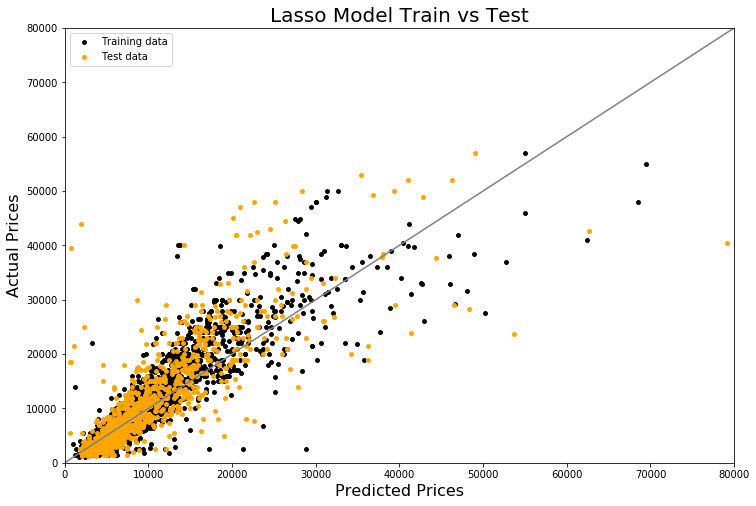

In [31]:
printMod(X_train_scaled,X_test_scaled,y_train,y_test,grid_lasso,"Lasso")

In [32]:
coeff = pd.DataFrame({"feature":X_train_scaled.columns,"coeff":grid_lasso.coef_})
coeff = coeff.sort_values(by = 'coeff', ascending = False)

print(coeff[coeff.coeff!=0].shape)
mod_=coeff[coeff.coeff!=0]
mod_

(284, 2)


,feature,coeff
0,year,0.382966
1344,cylinders_8 cylinders,0.079517
1371,type_truck,0.057082
1284,model_wrangler,0.046960
1219,model_transam,0.046086
240,model_c10,0.046058
727,model_impala ss,0.043701
782,model_little red express,0.041538
288,model_chevelle,0.038191
337,model_corvette,0.037593


In [33]:
coefs_lasso  = []

for alpha in alphas:
        grid_lasso.set_params(alpha=alpha)
        grid_lasso.fit(X_train_scaled, y_train)  
        coefs_lasso.append(grid_lasso.coef_)

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X_train_scaled.columns)  
coefs_lasso.head()

,year,odometer_log,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_nissan,manufacturer_pontiac,manufacturer_porche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo,model_1.8 quattro turbo sedan,model_1500,model_1500 4x4,model_1500 classic,model_1500 crew cab big horn,model_1500 crew cab bighorn,model_1500 crew cab outdoorsman,model_1500 crew outdoorsman,model_1500 hemi 4x4,model_1500 laramie 4x4,model_1500 quad cab 4x4,model_1500 rumble bee,model_1500 sierra,model_1500 slt,model_1500 slt 4x4,model_1500 slt 4x4. 5.7 hemi,model_1500 sport,model_200,model_200 limited,model_200 lx,model_200s,model_2014 terrain sle,model_250 gto,model_2500,model_2500 4x4,model_2500 4x4 extended cab,model_2500 big horn 4x4,model_2500 diesel,model_2500 diesel 4x4,model_2500 laramie,model_2500 mega cab 4x4,model_2500 passenger,model_2500 service truck,model_2500 slt 4x4 short bed,model_2500hd,model_280se 4.5,model_3,model_3 i touring,model_3 series 328i,model_3 series 328i sedan,model_3-series,model_3.5 rl,model_300,model_300 c,model_300 s,model_300 touring,model_3000gt,model_300m,model_300xl,model_300zx 2+2,model_325xi,model_328i,model_328i convertible,model_328i sport wagon,model_328i xdrive,model_328xi coupe2 door,model_330ci,model_330ci convertible,model_335d,model_335i,model_350,model_350 glk,model_3500,model_3500 hd diesel,model_3500 laramie,model_3500 laramie longhorn,model_3500 slt,model_3500 tradesman,model_3500 tradesman dually,model_3500 van,model_350z,model_350z-v6,model_370z,model_3i,model_435i gran coupe,model_4runner,model_4runner 4wd,model_4runner limited sr5,model_4runner sr5,model_4runner sr5 4wd,model_4runner sr5 4x4,model_5 series,model_5 series 530i,model_5 sport,model_500,model_500 abarth,model_500 c pop,model_528i xdrive,model_530i,model_535i,model_535i sedan,model_540i,model_5500,model_550i,model_6,model_6-series,model_6-series 650i convertible,model_6.2l,model_635csi,model_740il,model_740li x drive,model_745 li,model_750 li xdrive sport,model_750i,model_750li,model_840 ci,model_a3 1.8t premium,model_a4,model_a4 2.0t quattro,model_a4 quatro convertible,model_a4 quattro,model_a5,model_a5 2.0t quattro,model_a6 3.0t quattro,model_a6 quattro 2.7t s line,model_a7,model_a8 quattro,model_acadia,model_acadia sle,model_acadia slt-1,model_acadia slt2,model_accent,model_accent gls,model_accent se,model_accord,model_accord 2-door coupe,model_accord 4-door sedan,model_accord crosstour awd,model_accord ex,model_accord ex-l,model_accord ex-l v6,model_accord lx,model_accord lx sedan,model_accord lx sedan 4d,model_accord lx-p,model_accord sdn vp auto,model_accord sedan,model_accord.ex.coupe,model_according,model_altima,model_altima 2.5,model_altima 2.5 s,model_altima 2.5 sl,model_altima 3.5 se,model_altima s,model_altima se,model_armada,model_armada se,model_astro,model_astro cargo van,model_atlas se,model_ats,model_avalanche,model_avalanche 1500,model_avalanche c1500,model_avalanche ls,model_avalanche ltz,model_avalanche z71,model_avalon,model_avalon xl,model_avalon xls,model_avenger,model_avenger se,model_aveo,model_azera,model_b9 tribeca,model_beetle,model_beetle coupe,model_beetle gls,model_benz,model_benz c230,model_benz c240 4matic,model_benz c250,model_benz c300,model_benz c300 4matic,model_benz c320 4 matic,model_benz ces 500,model_benz cl550,model_benz clk350,model_benz e-350,model_benz e320,model_benz e320 4matic,model_benz e350,model_benz e350 4matic,model_

In [35]:
# Elastic Net
eNet = linear_model.ElasticNet(normalize=True)
eNet = eNet.set_params(random_state = 42)

#fit baseline elastic net model on Train df
eNet.fit(X_train_scaled,y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
eNet_pred = eNet.predict(X_test_scaled)
printErrors(y_test,eNet_pred)

Mean Absolute Error (MAE): $ 6657.15
Mean Squared Error (MSE): 0.5921240288971136
Root Mean Square Error (RMSE): 0.769495957687312
Root Mean Square Log Error (RMSLE): 0.07690764332662622
Mean Absolute Percent Error (MAPE): 75.25 %.


In [37]:
eNet.score(X_test_scaled,y_test)

-0.0005932042350187405

In [38]:
param_grid_eNet = {"max_iter": [10],
                    "alpha": [0.0002486947979395039],
                    "l1_ratio": [0.9]}
grid_search_eNet = ms.GridSearchCV(eNet, param_grid_eNet, scoring= 'neg_mean_squared_error', 
                                   cv= kfo, n_jobs=-1, return_train_score = True)

%time grid_search_eNet.fit(X_train_scaled, y_train)

Wall time: 492 ms


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=42, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0002486947979395039], 'l1_ratio': [0.9],
                         'max_iter': [10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [39]:
# Prediction using the tuned parameters
grid_eNet = grid_search_eNet.best_estimator_
grid_eNet_pred = grid_eNet.predict(X_test_scaled)

In [40]:
printErrors(y_test,grid_eNet_pred)

Mean Absolute Error (MAE): $ 3420.36
Mean Squared Error (MSE): 0.20368947565820525
Root Mean Square Error (RMSE): 0.45131970448696923
Root Mean Square Log Error (RMSLE): 0.04634907323941354
Mean Absolute Percent Error (MAPE): 32.86 %.


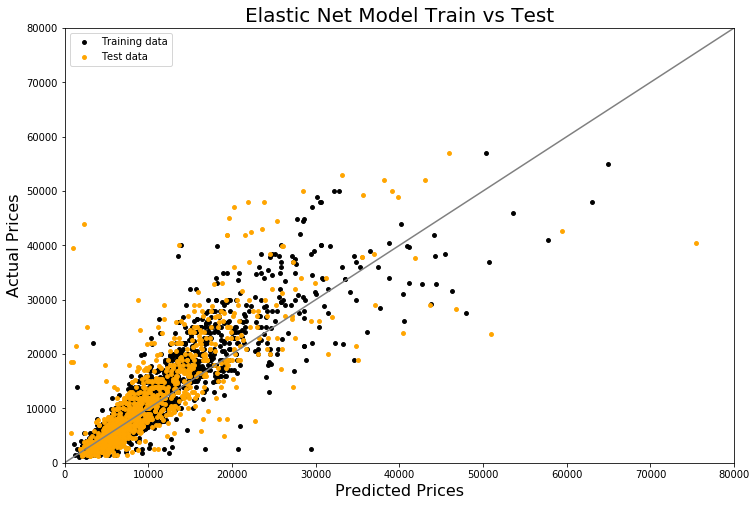

In [41]:
printMod(X_train_scaled,X_test_scaled,y_train,y_test,grid_eNet,"Elastic Net")

In [42]:
#initialize xgboost
xgb = XGBRegressor()
xgb.set_params(random_state=22,objective='reg:squarederror')
xgb.fit(X_train_scaled, y_train)
print("Train R^2 is: %.5f" % xgb.score(X_train_scaled, y_train))
print("Test set R^2 is is: %.5f" % xgb.score(X_test_scaled, y_test))

Train R^2 is: 0.82870
Test set R^2 is is: 0.77076


In [43]:
xgb_pred = xgb.predict(X_test_scaled)
printErrors(y_test, xgb_pred)

Mean Absolute Error (MAE): $ 2946.68
Mean Squared Error (MSE): 0.1356592018647292
Root Mean Square Error (RMSE): 0.3683194291165336
Root Mean Square Log Error (RMSLE): 0.037442247795790536
Mean Absolute Percent Error (MAPE): 28.73 %.


In [44]:
xgb_param_grid ={'learning_rate': [0.05],
                 'max_depth': [3],
                 'min_child_weight': [4],
                 'n_estimators': [500]}

grid_search_xgb = ms.GridSearchCV(xgb, xgb_param_grid, scoring='neg_mean_squared_error', 
                                     cv= kfo, n_jobs=-1, return_train_score = True)

In [45]:
%time grid_search_xgb.fit(X_train_scaled, y_train)

Wall time: 2min 25s


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=22, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.05], 'max_depth': [3],

In [46]:
grid_search_xgb.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 4,
 'n_estimators': 500}

In [47]:
grid_xgb = grid_search_xgb.best_estimator_

In [48]:
print("The train set R^2 is: %.5f" % grid_xgb.score(X_train_scaled, y_train))
print("The test set R^2 is is: %.5f" % grid_xgb.score(X_test_scaled, y_test))

The train set R^2 is: 0.85644
The test set R^2 is is: 0.78943


In [49]:
grid_xgb_pred = grid_xgb.predict(X_test_scaled)
printErrors(y_test, grid_xgb_pred)

Mean Absolute Error (MAE): $ 2817.26
Mean Squared Error (MSE): 0.12460739061124752
Root Mean Square Error (RMSE): 0.35299772040517136
Root Mean Square Log Error (RMSLE): 0.0359362530941975
Mean Absolute Percent Error (MAPE): 27.37 %.


In [50]:
xgb_param_grid1 ={'learning_rate': [0.05],
                 'max_depth': [3],
                 'min_child_weight': [4],
                 'n_estimators': [500],
                 'subsample': [0.7],
                 'colsample_bytree' : [0.7],
                 'objective':['reg:squarederror'],
                 'nthread':[-1],
                 'scale_pos_weight':[1],
                 'seed':[27],
                 'reg_alpha': [0.00006]}
                 

grid_search_xgb1 = ms.GridSearchCV(xgb, xgb_param_grid1, scoring='neg_mean_squared_error', 
                                     cv= kfo, n_jobs=-1, return_train_score = True)
%time grid_search_xgb1.fit(X_train_scaled, y_train)

Wall time: 1min 42s


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective...
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.05],
                         'max_depth': [3], 'min_child_weight': [4],
                         'n_estimators': [500], 'nthread': [-1],
                         'objective': ['reg:squarederror'],
                         'reg_alpha':

In [51]:
grid_search_xgb1.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 4,
 'n_estimators': 500,
 'nthread': -1,
 'objective': 'reg:squarederror',
 'reg_alpha': 6e-05,
 'scale_pos_weight': 1,
 'seed': 27,
 'subsample': 0.7}

In [52]:
grid_xgb1 = grid_search_xgb1.best_estimator_
print("The train set R^2 is: %.5f" % grid_xgb1.score(X_train_scaled, y_train))
print("The test set R^2 is is: %.5f" % grid_xgb1.score(X_test_scaled, y_test))

The train set R^2 is: 0.86559
The test set R^2 is is: 0.79672


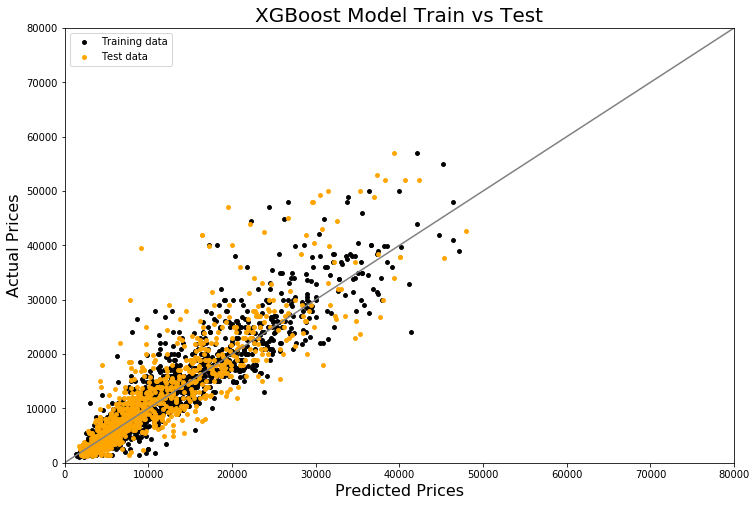

In [53]:
printMod(X_train_scaled,X_test_scaled, y_train,y_test,grid_xgb1,"XGBoost")

In [54]:
grid_xgb_pred1 = grid_xgb1.predict(X_test_scaled)

printErrors(y_test, grid_xgb_pred1)

Mean Absolute Error (MAE): $ 2798.84
Mean Squared Error (MSE): 0.12029422298855995
Root Mean Square Error (RMSE): 0.3468345758262286
Root Mean Square Log Error (RMSLE): 0.03524463773215019
Mean Absolute Percent Error (MAPE): 26.82 %.


In [55]:
# Get numerical feature importances
importances_xgb = list(xgb.feature_importances_)

# List of tuples with variable and importance
feature_importances_xgb = [(feature, round(importance, 5)) for feature, importance in zip(X_train_scaled.columns, importances_xgb)]

# Sort the feature importances by most important first
xgb_feature_importances = sorted(feature_importances_xgb, key = lambda x: x[1], reverse = True )

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in xgb_feature_importances]

Variable: year                 Importance: 0.1236800029873848
Variable: fuel_gas             Importance: 0.064690001308918
Variable: type_sedan           Importance: 0.058740001171827316
Variable: drive_fwd            Importance: 0.04907999932765961
Variable: cylinders_8 cylinders Importance: 0.039889998733997345
Variable: odometer_log         Importance: 0.039480000734329224
Variable: type_truck           Importance: 0.03415999934077263
Variable: cylinders_4 cylinders Importance: 0.031599998474121094
Variable: condition_good       Importance: 0.026489999145269394
Variable: size_full-size       Importance: 0.025909999385476112
Variable: condition_fair       Importance: 0.02442999929189682
Variable: condition_like new   Importance: 0.023429999127984047
Variable: state_tn             Importance: 0.02314000017940998
Variable: model_outlander sport Importance: 0.017869999632239342
Variable: manufacturer_mitsubishi Importance: 0.017270000651478767
Variable: manufacturer_ram     Importance: 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [56]:
xgb_feature_importances_top20 = xgb_feature_importances[:20]
featureNames, featureScores = zip(*list(xgb_feature_importances_top20))
xgb_feature_importances_top20

[('year', 0.12368),
 ('fuel_gas', 0.06469),
 ('type_sedan', 0.05874),
 ('drive_fwd', 0.04908),
 ('cylinders_8 cylinders', 0.03989),
 ('odometer_log', 0.03948),
 ('type_truck', 0.03416),
 ('cylinders_4 cylinders', 0.0316),
 ('condition_good', 0.02649),
 ('size_full-size', 0.02591),
 ('condition_fair', 0.02443),
 ('condition_like new', 0.02343),
 ('state_tn', 0.02314),
 ('model_outlander sport', 0.01787),
 ('manufacturer_mitsubishi', 0.01727),
 ('manufacturer_ram', 0.01723),
 ('model_wrangler', 0.01582),
 ('model_optima', 0.0133),
 ('drive_rwd', 0.01182),
 ('state_in', 0.01176)]

Text(0.5, 1.0, 'Feature Importances')

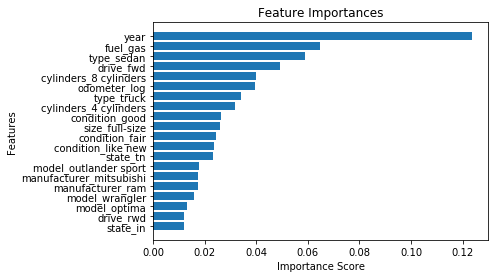

In [57]:
plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.gca().invert_yaxis()
plt.title('feature importance')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importances')

In [58]:
xgb_params_tuned_model = grid_search_xgb.best_estimator_
xgb_feature_importance = 100.0 * (xgb_params_tuned_model.feature_importances_ / xgb_params_tuned_model.feature_importances_.max())
xgb_important_features = X_train_scaled.columns[xgb_feature_importance >= 0.02]
xgb_unimportant_features = X_train_scaled.columns[xgb_feature_importance < 0.02]

In [59]:
xgb_important_features

Index(['year', 'odometer_log', 'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_cadillac', 'manufacturer_chevrolet', 'manufacturer_chrysler', 'manufacturer_dodge', 'manufacturer_ford', 'manufacturer_gmc',
       ...
       'state_ny', 'state_oh', 'state_pa', 'state_ri', 'state_sc', 'state_sd', 'state_tn', 'state_tx', 'state_wa', 'state_wy'], dtype='object', length=118)

In [60]:
X_train_xgbreduced = X_train_scaled.drop(xgb_unimportant_features, axis=1)
X_test_xgbreduced = X_test_scaled.drop(xgb_unimportant_features, axis=1)

In [61]:
# GridSearchCV for multiple hyperparameters:
xgb=XGBRegressor()

xgb_param_grid ={'learning_rate': [0.05, 0.1, 0.15],
             'max_depth': [3, 4, 5],
             'n_estimators': [500]}

xgb.set_params(random_state=42)

grid_search_xgb2 = ms.GridSearchCV(xgb, xgb_param_grid, scoring= 'neg_mean_squared_error',
                           cv= kfo, n_jobs = 7, return_train_score=True, verbose = 1)
grid_search_xgb2.fit(X_train_xgbreduced, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  45 out of  45 | elapsed:   53.9s finished


[11:11:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=42,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=7,
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
             

In [62]:
grid_search_xgb2.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}

In [63]:
predictions_tuned_xgb2 = grid_search_xgb2.best_estimator_.predict(X_test_xgbreduced)

In [64]:
printErrors(y_test, predictions_tuned_xgb2)

Mean Absolute Error (MAE): $ 2829.26
Mean Squared Error (MSE): 0.1251939940940213
Root Mean Square Error (RMSE): 0.35382763331037514
Root Mean Square Log Error (RMSLE): 0.03603328609221438
Mean Absolute Percent Error (MAPE): 27.62 %.


In [65]:
#initialize RF model
#default n estimators = 10 will be deprecated and changed to 100 by default in new version .22, 
#set parameter n_estimators to 10
rforest = RandomForestRegressor()

rforest.set_params(random_state=52,n_estimators=10,)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=52, verbose=0, warm_start=False)

In [66]:
#fit model on train data set
rforest.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=52, verbose=0, warm_start=False)

In [67]:
#find R2 of model on train and test data sets
print("The train set R^2 is: %.5f" % rforest.score(X_train_scaled, y_train))
print("The test set R^2 is is: %.5f" % rforest.score(X_test_scaled, y_test))

The train set R^2 is: 0.94801
The test set R^2 is is: 0.74044


In [68]:
rforest_pred = rforest.predict(X_test_scaled)

In [69]:
printErrors(y_test, rforest_pred)

Mean Absolute Error (MAE): $ 3125.28
Mean Squared Error (MSE): 0.15360177664695102
Root Mean Square Error (RMSE): 0.39192062544213085
Root Mean Square Log Error (RMSLE): 0.03969863579982982
Mean Absolute Percent Error (MAPE): 30.33 %.


In [70]:
# set parameter grid for kfold cross validation kfold is set above to 5
param_grid ={'max_depth': [20, 25, 30],
             'max_features': ['auto','sqrt','log2'],
             'min_samples_split':[2,3,4],
             'min_samples_leaf':[1, 3, 5],
             'n_estimators': [500]}

In [71]:
#test how different scoring impacts outcome...
grid_search_rforest = ms.GridSearchCV(rforest, param_grid, scoring='neg_mean_squared_error', 
                                     cv= kfo, n_jobs=-1, return_train_score = True)

In [72]:
%time grid_search_rforest.fit(X_train_scaled, y_train)

Wall time: 15min 1s


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_es..._jobs=None,
                                             oob_score=False, random_state=52,
                                             verbose=0, warm_sta

In [73]:
# get the best parameters
grid_search_rforest.best_params_

{'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [74]:
# Prediction using the tuned parameters
grid_rforest = grid_search_rforest.best_estimator_

In [75]:
print("The train set R^2 is: %.5f" % grid_rforest.score(X_train_scaled, y_train))
print("The test set R^2 is is: %.5f" % grid_rforest.score(X_test_scaled, y_test))

The train set R^2 is: 0.96544
The test set R^2 is is: 0.75989


In [76]:
#Prediction with tuned hyperparameters
grid_rforest_pred = grid_rforest.predict(X_test_scaled)

In [77]:

printErrors(y_test, grid_rforest_pred)

Mean Absolute Error (MAE): $ 2977.89
Mean Squared Error (MSE): 0.14209165219195696
Root Mean Square Error (RMSE): 0.37695046384366865
Root Mean Square Log Error (RMSLE): 0.038244116322121706
Mean Absolute Percent Error (MAPE): 29.42 %.


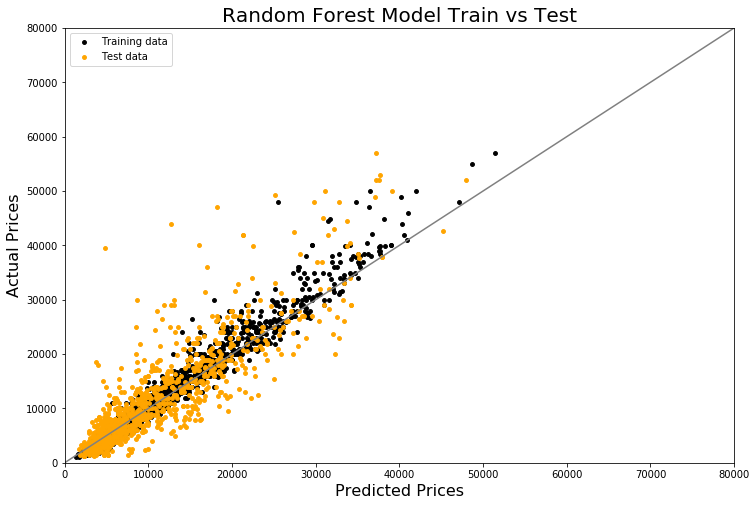

In [78]:
printMod(X_train_scaled,X_test_scaled,y_train,y_test,grid_rforest,"Random Forest")

In [79]:
# Random Forest Feature Importance 
# Get numerical feature importances
feats_rf = list(rforest.feature_importances_)

# List of tuples with variable and importance
feats_rf_score = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, feats_rf)]

# Sort the feature importances by most important first
sorted_feats_rf_score = sorted(feats_rf_score, key = lambda x: x[1], reverse = True )

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in sorted_feats_rf_score]

Variable: year                 Importance: 0.43999
Variable: odometer_log         Importance: 0.1089
Variable: drive_fwd            Importance: 0.08469
Variable: cylinders_8 cylinders Importance: 0.05261
Variable: fuel_gas             Importance: 0.04033
Variable: cylinders_4 cylinders Importance: 0.02488
Variable: condition_fair       Importance: 0.01501
Variable: type_truck           Importance: 0.01282
Variable: condition_good       Importance: 0.00957
Variable: manufacturer_ram     Importance: 0.00754
Variable: cylinders_6 cylinders Importance: 0.00596
Variable: type_sedan           Importance: 0.00583
Variable: manufacturer_toyota  Importance: 0.00558
Variable: drive_rwd            Importance: 0.00551
Variable: model_wrangler       Importance: 0.00536
Variable: type_pickup          Importance: 0.00482
Variable: paint_color_white    Importance: 0.00435
Variable: transmission_manual  Importance: 0.00427
Variable: manufacturer_chevrolet Importance: 0.00364
Variable: size_full-size   

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

Text(0.5, 1.0, 'Feature Importances')

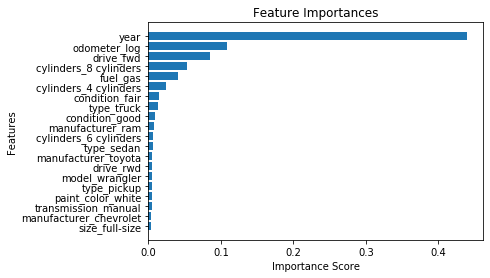

In [80]:
rf_feature_importances_top20 = sorted_feats_rf_score[:20]
featureNames, featureScores = zip(*list(rf_feature_importances_top20))

plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.gca().invert_yaxis()
plt.title('feature importance')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importances')

In [81]:
rf_feature_importances_top20

[('year', 0.43999),
 ('odometer_log', 0.1089),
 ('drive_fwd', 0.08469),
 ('cylinders_8 cylinders', 0.05261),
 ('fuel_gas', 0.04033),
 ('cylinders_4 cylinders', 0.02488),
 ('condition_fair', 0.01501),
 ('type_truck', 0.01282),
 ('condition_good', 0.00957),
 ('manufacturer_ram', 0.00754),
 ('cylinders_6 cylinders', 0.00596),
 ('type_sedan', 0.00583),
 ('manufacturer_toyota', 0.00558),
 ('drive_rwd', 0.00551),
 ('model_wrangler', 0.00536),
 ('type_pickup', 0.00482),
 ('paint_color_white', 0.00435),
 ('transmission_manual', 0.00427),
 ('manufacturer_chevrolet', 0.00364),
 ('size_full-size', 0.00364)]

In [82]:
grid_rforest = grid_search_rforest.best_estimator_
feature_importance = 100.0 * (grid_rforest.feature_importances_ / grid_rforest.feature_importances_.max())
important_features = X_train.columns[feature_importance >= 0.05]
unimportant_features = X_train.columns[feature_importance < 0.05]

In [83]:
X_train_reduced = X_train.drop(unimportant_features, axis=1)
X_test_reduced = X_test.drop(unimportant_features, axis=1)

In [84]:
rForest_feats = RandomForestRegressor()

param_grid ={'max_depth': [10, 20, 30, 40, 50],
             'max_features': ['auto','sqrt','log2'],
             'min_samples_split':[2,3,4],
             'n_estimators': [100, 300, 500, 800]}

rForest_feats.set_params(random_state=42)

grid_search_rForest2 = ms.GridSearchCV(rForest_feats, param_grid, scoring= 'neg_mean_squared_error',
                           cv= kfo, n_jobs = -1, return_train_score=True, verbose = 1)
grid_search_rForest2.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 13.3min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_es...ors=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0

In [85]:
# get the best parameters
grid_search_rForest2.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 800}

In [86]:
predictions_tuned_rForest2 = grid_search_rForest2.best_estimator_.predict(X_test_reduced)

# Calculate the absolute errors
errors = abs(np.expm1(predictions_tuned_rForest2) - np.expm1(y_test))

# Print out the mean absolute error (MAE)
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('MSE:', mean_squared_error(y_test, predictions_tuned_rForest2))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions_tuned_rForest2)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(y_test))

# Calculate and display MAPE
#accuracy = 100 - np.mean(mape)
print('MAPE:', round(np.mean(mape), 2), '%.')

Mean Absolute Error (MAE): $ 2962.04
MSE: 0.1418325114066149
RMSE: 0.37660657376978285
MAPE: 29.77 %.


In [91]:
stackMod = StackingCVRegressor(regressors=(grid_lasso,grid_eNet,grid_xgb1,grid_rforest),
                              meta_regressor = grid_xgb, shuffle = True,
                              random_state = 20,
                              use_features_in_secondary= True)
%time stackMod.fit(X_train_scaled,y_train)

Wall time: 6min 41s


StackingCVRegressor(cv=5,
                    meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=1, gamma=0,
                                                importance_type='gain',
                                                learning_rate=0.05,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=4,
                                                missing=None, n_estimators=500,
                                                n_jobs=1, nthread=None,
                                                objective='reg:squarederror',
                                                random_state=22, reg_alpha=0,...
                                

In [92]:
print("Train R^2: %.5f" % stackMod.score(np.array(X_train_scaled), np.array(y_train)))
print("Test R^2: %.5f" % stackMod.score(np.array(X_test_scaled), np.array(y_test)))

Train R^2: 0.90567
Test R^2: 0.79747


In [93]:
# Initial prediction
stackMod_pred = stackMod.predict(np.array(X_test_scaled))

In [94]:
printErrors(y_test, stackMod_pred)

Mean Absolute Error (MAE): $ 2775.22
Mean Squared Error (MSE): 0.11985387483661039
Root Mean Square Error (RMSE): 0.3461991837607512
Root Mean Square Log Error (RMSLE): 0.035151309991740355
Mean Absolute Percent Error (MAPE): 26.6 %.


In [95]:
stackModModwoElas = StackingCVRegressor(regressors=(grid_lasso,grid_xgb1,grid_rforest),
                              meta_regressor = grid_xgb, shuffle = True,
                              random_state = 20,
                              use_features_in_secondary= True)
%time stackModModwoElas.fit(np.array(X_train_scaled),np.array(y_train))

Wall time: 6min 59s


StackingCVRegressor(cv=5,
                    meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=1, gamma=0,
                                                importance_type='gain',
                                                learning_rate=0.05,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=4,
                                                missing=None, n_estimators=500,
                                                n_jobs=1, nthread=None,
                                                objective='reg:squarederror',
                                                random_state=22, reg_alpha=0,...
                                

In [96]:
print("Train R^2: %.5f" % stackModModwoElas.score(np.array(X_train_scaled), np.array(y_train)))
print("Test R^2: %.5f" % stackModModwoElas.score(np.array(X_test_scaled), np.array(y_test)))

Train R^2: 0.90572
Test R^2: 0.79751


In [97]:
# Initial prediction
stackModwoElas_pred = stackModModwoElas.predict(np.array(X_test_scaled))

In [98]:
printErrors(y_test, stackModwoElas_pred)

Mean Absolute Error (MAE): $ 2784.45
Mean Squared Error (MSE): 0.11983004101250398
Root Mean Square Error (RMSE): 0.3461647599229361
Root Mean Square Log Error (RMSLE): 0.03513323277317577
Mean Absolute Percent Error (MAPE): 26.68 %.
